In [696]:
# собрал все import вместе, чтобы было удобно запускать
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from sklearn.naive_bayes import CategoricalNB
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_auc_score

# student distr for № 4
from scipy.stats import t
from joblib import Parallel, delayed


## 1

![Alt text](1.jpg)
![Alt text](2.jpg)


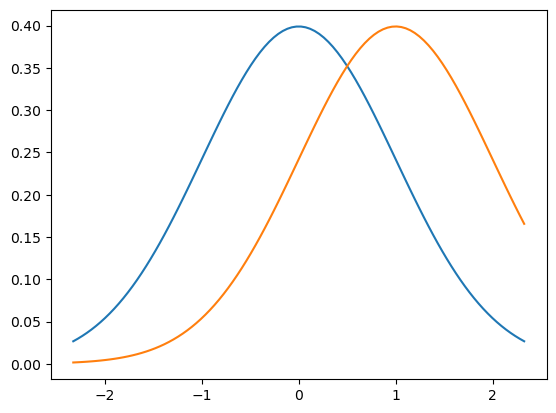

In [43]:
mu = 0
scale = 1
n = 100

x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
plt.plot(x, norm.pdf(x, loc = mu, scale = np.sqrt(scale)))
plt.plot(x, norm.pdf(x, loc = 0.1 * np.sqrt(n) / scale, scale = np.sqrt(scale)))

## task2

Используем модель, которая на объекте $X$ выдает вероятности классов как в порождающей модели. То есть $p(x = 1) = \sigma(wX)$

![Alt text](3.jpg)
![Alt text](4.jpg)

эта часть не доведена. Не смог посчитать интеграл

![Alt text](5.jpg)
![Alt text](6.jpg)

Эксперимент для (а). Видим, что все измерения AUC получаются близкими к 1

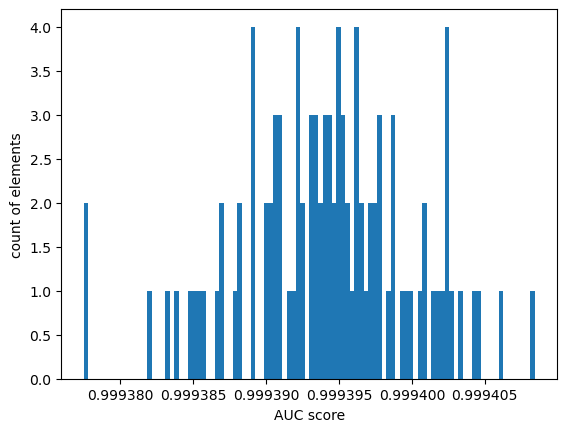

In [513]:
from sklearn.metrics import roc_auc_score
num_tests = 100
def log_reg(x, w):
    return 1/ (1 + np.exp(- x @ w))
n = 10
m = 1000000
sigma = 10
alpha = 1

w = np.random.normal(loc = 0, scale = 1/alpha, size = (n,))

X = np.random.normal(loc = 0, scale = sigma, size=(m, n))
auc_scores = []
for _ in range(num_tests):
    probs = log_reg(X, w)
    y = np.random.rand(m) < probs
    auc = roc_auc_score(y, probs)
    auc_scores.append(auc)
plt.hist(auc_scores, 100)
plt.xlabel("AUC score")
plt.ylabel('count of elements')
plt.show()

Эксперименты для (б). Фиксируем выборку и семплируем $w_0$, на этих $w_0$ считаем AUC. После этого усредняем. Получается большая дисперсия, так как $w$ в равной вероятностью смотрит в разные стороны.

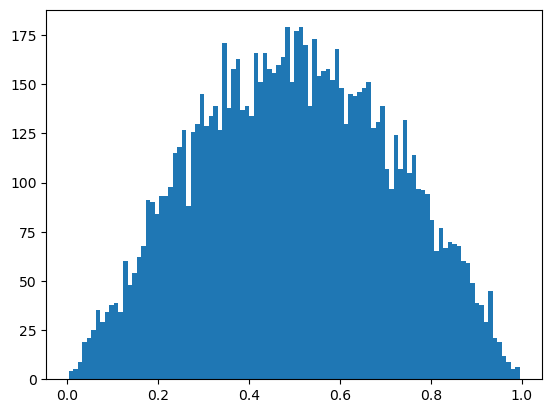

In [35]:
# семплирование для одного m
from sklearn.metrics import roc_auc_score
num_tests = 10000
def log_reg(x, w):
    return 1/ (1 + np.exp(- x @ w))
n = 5
m = 1000
sigma = 10
alpha = 1

w = np.random.normal(loc = 0, scale = 1/alpha, size = (n,))
auc_scores = []
for _ in range(num_tests):
    w_2 = np.random.normal(loc = 0, scale = 1/alpha, size = (n,))
    X = np.random.normal(loc = 0, scale = sigma, size=(m, n))
    probs = log_reg(X, w)
    y = np.random.rand(m) < probs

    my_probs = log_reg(X, w_2)
    auc = roc_auc_score(y, my_probs)
    auc_scores.append(auc)
plt.hist(auc_scores, 100)
plt.show()

семплирование при разных m

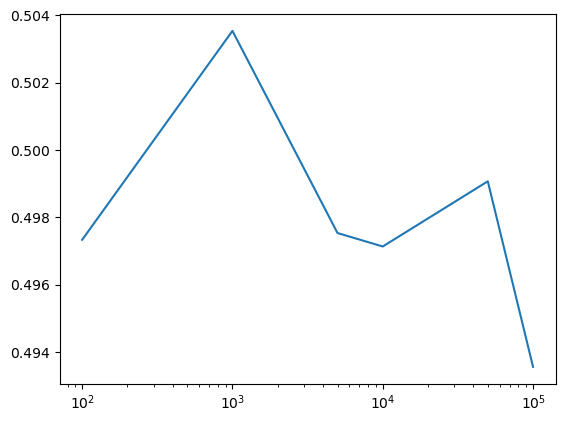

In [547]:
from sklearn.metrics import roc_auc_score
num_tests = 3000
m_s = [100, 1000, 5000, 10000, 50_000, 100_000]

mean_aucs = np.zeros_like(m_s, dtype=float)

def log_reg(x, w):
    return 1/ (1 + np.exp(- x @ w))

n = 5
sigma = 10
alpha = 1

w = np.random.normal(loc = 0, scale = 1/alpha, size = (n,)) # фиксируем этот вектор

def sample_auc(m):
    w_2 = np.random.normal(loc = 0, scale = 1/alpha, size = (n,))

    X = np.random.normal(loc = 0, scale = sigma, size=(m, n))
    probs = log_reg(X, w)
    y = np.random.rand(m) < probs
    my_probs = log_reg(X, w_2)
    auc = roc_auc_score(y, my_probs)
    return auc

sample_auc_del = delayed(sample_auc)

for i, m in enumerate(m_s):
    aucs = np.array(Parallel(n_jobs= 8)(sample_auc_del(m) for _ in range(num_tests)))
    mean_aucs[i] = np.mean(aucs)

plt.plot(m_s, mean_aucs)
plt.xscale('log')
plt.show()


получили, что ожидаемое значение $AUC = 0.5$

## 3

![Alt text](7.jpg)
![Alt text](8.jpg)


## 4

![Alt text](9.jpg)
![Alt text](10.jpg)

In [588]:
# реализация критерия
def T(X, Y):
    n = len(X)
    m = len(Y)
    x_mean = np.mean(X, axis = 0)
    y_mean = np.mean(Y, axis = 0)
    disp_x =  np.sum((X - x_mean[None, :])**2, axis = 0) # не поделил на n-1 так как надо умножить в disp
    disp_y =  np.sum((Y - y_mean[None, :])**2, axis = 0)
    disp = (disp_x + disp_y) / (n + m - 2) 
    disp = disp ** 0.5
    statistics = ((x_mean - y_mean) / disp ) / ((1 / n + 1/ m)**0.5)
    
    distr = t(n + m - 2)                                    # распределение стьюдента с такими параметрами
    p_values = 2 * distr.cdf(-np.abs(statistics))           # потому что распределение симметричное
    return statistics, p_values


#                           генератор данных
def generate(m1, m2, n, j):
    X = np.zeros((m1, n))
    Y = np.zeros((m2, n))
    for i in range(1,n + 1):
        X[:, i-1] = np.random.normal(loc = 0, scale= i **0.5, size = (m1,))
        Y[:, i-1] = np.random.normal(loc = 0, scale = i**0.5, size = (m2, ))
    # сдвигаем j признак на 1
    Y[:, j] += 1
    return X, Y


def make_table(p_val, j, alpha):
    # делает табличку принятых и отвергнутых гипотез как на лекции
    # для всех элементов кроме j выполняется первая гипотеза
    m = len(p_val)
    predictions = crit(p_val, alpha)
    m0_ = np.concatenate([predictions[:j], predictions[j+1:] if j + 1 < m else []])
    m0 = len(m0_)
    U = np.sum(m0_)
    V = m0 - U
    falses = predictions[j]
    T = falses    # если принят, то 1, но это значит ошибочно принято
    S = m - m0 - T
    table = np.array(
        [[U, T, m - V- S],
         [V, S, V + S],
         [m0, m-m0, m]]
    )
    rez = pd.DataFrame(table, index = [r"# принятых $H_0$",r"# отвергнутых $H_0$",r"Всего"],
                       columns= [r"# верных",r"# неверных",r"Всего"])
    return rez

def Behjamin_hohberg(p_val, alpha):                              # вызывалка поправки
    _, pv, *_ = multipletests(p_val, alpha, method = 'fdr_bh')
    return pv

def crit(p_val, alpha):                                         # применение критеря к p_value
    return p_val > alpha 


пример применения критерия при $n = 100$

In [650]:
n = 100
j = 4 # для j = 0 дисперсия равна 1
m1, m2 = 500, 500
# пункт в. реализация метода выше
alpha = 0.05
X, Y = generate(m1, m2, n, j)
stats, p_vals = T(X, Y)
print(f'p_value and statistics of feature with different expectation: {p_vals[j], stats[j]}')
p_vals = Behjamin_hohberg(p_vals, alpha)
table = make_table(p_vals, j, alpha)
display(table)


p_value and statistics of feature with different expectation: (2.514737283309866e-12, -7.091191125983536)


,# верных,# неверных,Всего
# принятых $H_0$,99,0,99
# отвергнутых $H_0$,0,1,1
Всего,99,1,100


метод отличает координату с неверной гипотезой при небольших j, при больших уже отличается реже. Это связано с тем, что дисперсия переменных влияет на мощность критерия примерно как в первой задаче

In [693]:
from joblib import Parallel, delayed
n_jobs = 12
alpha = 0.05

def test_all(m1, m2, n, j, correction = False):
    X, Y = generate(m1, m2, n, j)
    stats, p_vals = T(X, Y)
    if correction:
        p_vals = Behjamin_hohberg(p_vals, alpha)
    table = make_table(p_vals, j, alpha)
    return table.iloc[1, 0], table.iloc[1, 1], table.iloc[1,2 ] # true reject and false reject and summ reject

test_all_parallel = delayed(test_all)

m1_s =[2, 10, 30, 100, 500]
m2_s =[2, 10, 30, 100, 500]
n_iters = 10000
j = 2
def meshgrid_test(correction = False):

    mesh = np.meshgrid(m1_s, m2_s)
    rejected_true = np.ones_like(mesh[0], dtype=float)
    rejected_false = np.ones_like(mesh[0], dtype = float)
    for i in range(mesh[0].shape[0]):
        for j in range(mesh[0].shape[1]):
            m1, m2 = mesh[0][i][j],  mesh[1][i][j]
            lst = np.array(Parallel(n_jobs= n_jobs)(test_all_parallel(m1, m2, n, j, correction) for _ in range(n_iters))).T
            lst[:2, lst[2] > 0] = lst[:2, lst[2] > 0] / lst[2, lst[2] > 0]
            lst[:2, lst[2] == 0] = 0
            lst = lst.mean(axis = 1)        
            rejected_true[i,j] = lst[0]
            rejected_false[i, j] = lst[1]

    # rejected_true = rejected_true # /n_iters
    # rejected_false = rejected_false#  /n_iters
    return rejected_true, rejected_false

![Alt text](табличка.png)

Далее в табличках mean($\frac{V}{R} I (R > 0)$) для ошибочных отклонений и mean($\frac{S}{R} I (R > 0)$) для правильных отклонений. 

Можно видеть, что при отсутствии поправок доля правильных отклонений оставляет желать лучшего, даже если неверная гипотеза распознается во всех тестах. 

Но после внесения поправок FDR падает, и доля правильно отклоненных гипотез становится больше и растет с ростом размеров выборки

In [695]:
rejected_true, rejected_false = meshgrid_test()
print("без поправки p_values")
print("indices is m2, columns is m1\n сейчас рассмотрим ")
print('reject false classes (правилььно отклонено):')
display(pd.DataFrame(rejected_false, index = m2_s, columns=m1_s))
print('reject true classes (ошибочно отклонено) :')
display(pd.DataFrame(rejected_true, index = m2_s, columns=m1_s))

без поправки p_values
indices is m2, columns is m1
 сейчас рассмотрим 
reject false classes (правилььно отклонено):


,2,10,30,100,500
2,0.0005,0.0009,0.0012,0.0005,0.0004
10,0.0012,0.0024,0.0022,0.0021,0.0013
30,0.0012,0.0020,0.0035,0.0042,0.0025
100,0.0011,0.0033,0.0056,0.0066,0.0051
500,0.0014,0.0029,0.0057,0.0063,0.0075


reject true classes (ошибочно отклонено) :


,2,10,30,100,500
2,0.9012,0.8624,0.8736,0.8888,0.9016
10,0.7816,0.6666,0.6573,0.6782,0.7057
30,0.7337,0.5221,0.4070,0.3315,0.3322
100,0.7106,0.4327,0.2106,0.0613,0.0196
500,0.7053,0.3953,0.1337,0.0038,0.0000


теперь применим поправку, и получим более красивую табличку

In [685]:
rejected_true, rejected_false = meshgrid_test(correction = True)
print("применили поправки бенжамина хохберга")
print("indices is m2, columns is m1\n сейчас рассмотрим ")
print('reject false classes (правилььно отклонено):')
display(pd.DataFrame(rejected_false, index = m2_s, columns=m1_s))
print('reject true classes (ошибочно отклонено) :')
display(pd.DataFrame(rejected_true, index = m2_s, columns=m1_s))

применили поправки бенжамина хохберга
indices is m2, columns is m1
 сейчас рассмотрим 
reject false classes (правилььно отклонено):


,2,10,30,100,500
2,0.0004,0.0023,0.0027,0.0029,0.0023
10,0.0053,0.0160,0.0204,0.0180,0.0149
30,0.0107,0.0426,0.0770,0.1142,0.1219
100,0.0149,0.0713,0.1941,0.4459,0.6512
500,0.0178,0.0950,0.3052,0.7749,0.9087


reject true classes (ошибочно отклонено) :


,2,10,30,100,500
2,0.0494,0.0491,0.0485,0.0475,0.0461
10,0.0492,0.0519,0.0468,0.0498,0.0476
30,0.0451,0.0454,0.0405,0.0368,0.0378
100,0.0492,0.0447,0.0371,0.0207,0.0100
500,0.0465,0.0382,0.0307,0.0047,0.0000


## 5

PCA это метод понижения размерности данных. Постановки задачи могут быть разные. Например 

"понизить размерность и сохранить разброс данных при проекции на подпространство"

также можно переформулировать задачу как декорреляция фич.



В обозначениях ниже C -- эмпирическая матрица ковариаций. Она с множителем $\frac{1}{m}$ так как мы знаем что среднее = 0, и это является несмещенной оценкой ковариации.

а) матрица в ожидании получается диагональная размера $n \times n $ с элементами $\sigma^2$


![Alt text](11.jpg)![Alt text](12.jpg)

In [697]:
from sklearn.decomposition import PCA
n = 10
m = 1000
k = 10
def get_data(n,m,k):
    xi1 = np.random.normal(loc = 0., scale=1., size = (m,1))
    xi2 = np.random.normal(loc = 0., scale=1., size = (m,))

    X = np.zeros(shape= (m, n))
    X[:, :n-1] = xi1 + np.random.normal(loc = 0., scale=1., size = (m, n-1))
    X[:,n-1] = k * xi2
    return X

Случай k^2 > n

In [699]:
n = 100
m = 10000
k = 60
X = get_data(n,m,k)
pca = PCA(n_components=1,svd_solver='arpack')
pca.fit(X)

true_h = np.zeros((n))
true_h[-1] = 1
print(f'explained variacer ratio: {(pca.explained_variance_ratio_)}')
print(f'MSE diff true between true vector and result vector {np.linalg.norm(true_h - pca.components_)/n}')
print(f"vector components: \n{pca.components_}")

explained variacer ratio: [0.94798421]
MSE diff true between true vector and result vector 0.019999993397863285
vector components: 
[[ 1.75460465e-04  6.84071342e-05 -1.38601419e-04  2.88155661e-05
   1.99093183e-04 -2.18173801e-04  2.42701112e-04 -1.03322146e-05
   3.42769634e-05  1.48924650e-04 -9.16590273e-05 -9.09405198e-06
   7.41754906e-05  1.69964601e-04 -1.08899929e-04 -4.74783790e-04
   1.04041645e-05  3.00261609e-05  9.19207921e-05  3.70082828e-06
  -1.14493642e-04  1.95611177e-04 -1.27253257e-04  2.38877195e-06
   1.11149230e-04 -2.57590339e-04 -8.83423403e-05  2.15174589e-04
  -1.08076921e-04 -1.85169713e-04 -9.29671697e-06 -2.85489626e-04
   1.96963993e-04  3.59237429e-05  9.43097940e-05  5.83764040e-05
  -1.03087438e-04 -1.78316803e-04 -1.47891368e-04  2.33009746e-05
  -3.24350747e-06  4.02489511e-04 -3.18636926e-05  5.07697176e-05
  -7.35197325e-05 -3.60218439e-04 -7.41392592e-05  1.15038431e-06
  -7.55565006e-05  2.14146867e-05  2.48947711e-04  1.51986302e-04
   1.19224

случай $n > k^2$. Объясненная дисперсия $\approx n$,

In [700]:
n = 100
m = 1000000
k = 8
X = get_data(n,m,k)
pca = PCA(n_components=1,svd_solver='arpack')
pca.fit(X)
true_h = np.ones((n))
true_h[-1] = 0

print(f'explained variace ratio: {(pca.explained_variance_ratio_)}')
print(f'MSE diff true between true vector and result vector {np.linalg.norm(true_h - pca.components_)/n}')
print(f"vector components: \n{pca.components_}")

explained variace ratio: [0.38171439]
MSE diff true between true vector and result vector 0.10949873572097994
vector components: 
[[-0.10051255 -0.10058834 -0.10047151 -0.100416   -0.10049319 -0.10061797
  -0.10064058 -0.10054591 -0.10058166 -0.10051839 -0.10062572 -0.10044999
  -0.1005728  -0.10053806 -0.10073665 -0.10053965 -0.10046406 -0.10053443
  -0.10059763 -0.10066385 -0.10053781 -0.10053254 -0.10048416 -0.10053172
  -0.1003725  -0.10048489 -0.10032788 -0.10035895 -0.10044649 -0.10069834
  -0.10055661 -0.10047021 -0.10043868 -0.10052528 -0.10047826 -0.10031291
  -0.10066033 -0.10051778 -0.1004765  -0.10045472 -0.10057408 -0.10043819
  -0.10041013 -0.10051162 -0.10052985 -0.10039129 -0.1005343  -0.10059063
  -0.10048723 -0.10058351 -0.10043865 -0.10048713 -0.10045701 -0.10068311
  -0.10038438 -0.10063068 -0.10044106 -0.10064971 -0.10041924 -0.10050148
  -0.10043524 -0.10040514 -0.10054582 -0.10047629 -0.10049334 -0.10043475
  -0.10048139 -0.10048253 -0.10052803 -0.10046    -0.100

In [511]:
n = 100
m = 1000000
k = 8
X = get_data(n,m,k)
pca = PCA(n_components=3,svd_solver='arpack')
pca.fit(X)

print("рассмотрим первые 3 компоненты:")
print(f'explained variace: {(pca.explained_variance_)}')

рассмотрим первые 3 компоненты:
explained variace: [99.83581769 63.99345461  1.01908094]


Практический вывод: если в данных есть зависимые признаки, то можно сильно уменьшить их размерность, причем не теряя дисперсию. Это наглядно можно увидеть в последней ячейке, где уже третья компонента описывает маленькую часть дисперсии по сравнению с первыми компонентами.